# Układy równań liniowych oraz różne sposoby ich rozwiązywania

## Przykładowy układ równań i sposób jego przedstawienia za pomocą macierzy
Taki układ równań:
$$
    \begin{cases}
        2.3x_1 - 3.4x_2 + 0.66x_3 = 13.1 \\ \\
        -0.23x_1 + 6.2x_2 + 12.2x_3 = 2.0 \\ \\
        22.12x_1 + 3.33x_2 - 7.89x_3 = -23.12
    \end{cases}
$$
można zapisać za pomocą macierzy w ten sposób:
$$
    \begin{bmatrix}
        2.3 & -3.4 & 0.66 \\
        -0.23 & 6.2 & 12.2 \\
        22.12 & 3.33 & -7.89
    \end{bmatrix}
    *
    \begin{bmatrix}
        x_1 \\
        x_2 \\
        x_3
    \end{bmatrix}
    =
    \begin{bmatrix}
        13.1 \\
        2.0 \\
        -23.12
    \end{bmatrix}
$$
gdzie kolejno $\textbf{A}$ to macierz podstawowa (główna) układu, $\textbf{x}$ to wektor niewiadomych oraz $\textbf{b}$ to wektor wyrazów wolnych. Ogólnie równanie macierzowe przedstawiamy więc, w następujący sposób:

$$ \textbf{A} * \textbf{x} = \textbf{b} $$

Spotkać się też można z macierzą zawierającą wyrazy wolne, należy to traktować jak wiele układów równań, gdzie każdy składa się z takich samych współczynników oraz dla każdego układu przypisujemy kolejne kolumny macierzy wyrazów wolnych.

## Analiza sposobów rozwiązywania układów macierzowych

### Dane testowe
Jako dane testowe przyjmujemy macierz pasmową. Macierz pasmowa (wstęgowa) to kwadratowa macierz rzadka, której wszystkie elementy są zerowe poza diagonalą i pasmem (wstęgą) wokół niej. Mając daną macierz $n \times n$, jej elementy $a_{i,j}$ są niezerowe, gdy $i-k_{1} \leqslant j \leqslant i+k_{2}$, gdzie $k_{1,2}\geqslant 0$ określają tzw. szerokość pasma. Jednak aby uprościć obliczenia, będziemy operować na macierzach w formacie pełnym.

Nasza macierz główna będzie wymiaru $934 \times 934, k_1 = k_2 = 2$ oraz będzie zawierać następujące elementy:

$$
  \textbf{A} =
  \begin{bmatrix}
    14 & -1 & -1 & 0 & 0 & 0 & 0 & \cdots & 0 \\
    -1 & 14 & -1 & -1 & 0 & 0 & 0 & \cdots & 0 \\
    -1 & -1 & 14 & -1 & -1 & 0 & 0 & \cdots & 0 \\
    0 & -1 & -1 & 14 & -1 & -1 & 0 & \cdots & 0 \\
    \vdots &  & \ddots & \ddots & \ddots & \ddots & \ddots &  & \vdots \\
    0 & \cdots & 0 & -1 & -1 & 14 & -1 & -1 & 0 \\
    0 & \cdots & 0 & 0 & -1 & -1 & 14 & -1 & -1 \\
    0 & \cdots & 0 & 0 & 0 & -1 & -1 & 14 & -1 \\
    0 & \cdots & 0 & 0 & 0 & 0 & -1 & -1 & 14 \\
  \end{bmatrix}
$$
wektor wyrazów wolnych:

$$
  \textbf{b} =
  \begin{bmatrix}
    sin(0) \\
    sin(5) \\
    sin(10) \\
    \vdots \\
    sin(525) \\
    sin(530) \\
    sin(535)
  \end{bmatrix}
$$


In [1]:
from math import sin, sqrt, isinf
from matrix import *
from matplotlib import pyplot as plt
from copy import deepcopy
import time


def generate_test_data(size: int, a_1: float, a_2: float, a_3: float, f_4: int):
    a = Matrix(size)
    for i in range(a.rows):
        for j in range(a.cols):
            if i == j:

                a[i, j] = a_1
            else:
                distance = abs(i - j)
                if distance == 1:
                    a[i, j] = a_2
                if distance == 2:
                    a[i, j] = a_3

    b = Matrix(size=(size, 1))
    for i in range(b.rows):
        b[i, 0] = sin(i * (f_4 + 1))

    return a, b


my_index = "184934"
n = int("9" + my_index[len(my_index) - 2] + my_index[len(my_index) - 1])
a1 = 5 + float(my_index[3])
a2 = a3 = -1.0
f = int(my_index[2])
matrix_a, vector_b = generate_test_data(n, a1, a2, a3, f)

### Metody iteracyjne
Jako pierwsze testować będziemy metody iteracyjne, a konkretnie metodę Jacobiego oraz metodą Gaussa-Seidla. Metody iteracyjne to metody, które nie uzyskują dokładnego rozwiązania, a tylko jego przybliżenie, w zamian za szybkość działania.

Bardzo ważne dla algorytmów iteracyjnych jest określenie, w jakim momencie osiągnęliśmy satysfakcjonujące przybliżenie rozwiązania. W tym celu skorzystamy z tzw. *wektora residuum*:

$$
    \textbf{res} = \textbf{A}\textbf{x} - \textbf{b}
$$

Wielkość błędu natomiast jesteśmy w stanie zbadać, określając jego normę euklidesową.

$$
    ||\textbf{e}||_2 = \sqrt{\sum_{j=1}^{n}e_j^2}
$$

In [2]:
def euclidean_norm(vec: Matrix):
    return sqrt(sum([vec[i, 0] ** 2 for i in range(vec.rows)]))

#### Metoda Jacobiego
Metoda Jacobiego to jedna z metod iteracyjnych. Do wyliczenia kolejnych wektorów przybliżeń, używany jest wektor z poprzedniej iteracji. Mimo że część obecnego wektora jest już wyliczona.

Pierwszym krokiem jest rozbicie macierzy systemowej na trzy macierze: $\textbf{A} = -\textbf{L} -\textbf{U} + \textbf{D}$, gdzie kolejno macierz $\textbf{L}$ to macierz trójkątna dolna, zawierająca liczby przeciwne **poniżej** głównej diagonali macierzy $\textbf{A}$, macierz $\textbf{U}$ to macierz trójkątna górna, zawierająca liczby przeciwne **powyżej** głównej diagonali macierzy $\textbf{A}$, macierz $\textbf{D}$ to macierz diagonalna, zawierająca liczby z głównej diagonali macierzy $\textbf{A}$.

Przekształcając równanie $\textbf{A}*\textbf{x}=\textbf{b}$, wykorzystując powyższą równość otrzymujemy:
$$
    (-\textbf{L} - \textbf{U} + \textbf{D})\textbf{x} = \textbf{b}
$$
po serii przekształceń:
$$
    \textbf{D}\textbf{x} = (\textbf{L} + \textbf{U})\textbf{x} + \textbf{b} \\
    \textbf{x} = \textbf{D}^{-1}(\textbf{L} + \textbf{U})\textbf{x} + \textbf{D}^{-1}\textbf{b} \\
$$
otrzymujemy ostateczny wzór:
$$
    \tilde{\textbf{x}}^{(n+1)} = \textbf{D}^{-1}(\textbf{L} + \textbf{U})\tilde{\textbf{x}}^{(n)} + \textbf{D}^{-1}\textbf{b}
$$
gdzie $(n)$ oznacza n-tą iteracje.

Metoda ta wykorzystuje szybkie obliczeniowo rozwiązywanie układów równań zapisanych za pomocą macierzy **diagonalnych**, opisane takim wzorem:
$$
    x_i = \frac{b_i}{a_{ii}}
$$
gdzie $i$ to kolejne indeksy rzędów.

In [3]:
def jacobi(a: Matrix, b: Matrix, epsilon: float):
    x = Matrix(size=(a.rows, 1))
    it = 0

    upper = -a.tri_u(1)
    lower = -a.tri_l(1)
    diagonal = a.diag()

    const_1 = diagonal_solver(diagonal, lower + upper)
    const_2 = diagonal_solver(diagonal, b)
    
    residuum_norm_list = []
    while True:
        it += 1
        x = const_1 * x + const_2

        residuum = a * x - b
        norm = euclidean_norm(residuum)
        residuum_norm_list.append(norm)
        if norm <= epsilon or isinf(norm):
            break
    return it, residuum_norm_list, x

### Metoda Gaussa-Seidla
Metoda Gaussa-Seidla to kolejna metoda iteracyjna, bardzo podobna to poprzednio opisanej. Jednak, zamiast używać wektora przybliżenia z poprzedniej iteracji, używamy najnowszych danych.

Również stosujemy podział na trzy macierze $\textbf{L}, \textbf{U}, \textbf{D}$. Przekształcenia nieco się różnią:
$$ (-\textbf{L} - \textbf{U} + \textbf{D})\textbf{x} = \textbf{b} $$
$$ (\textbf{D} - \textbf{L})\textbf{x} = \textbf{U}\textbf{x} + \textbf{b} $$
$$ \textbf{x} = (\textbf{D} - \textbf{L})^{-1}(\textbf{U}\textbf{x}) + (\textbf{D} - \textbf{L})^{-1}\textbf{b} $$
$$ \tilde{\textbf{x}}^{(n+1)} = (\textbf{D} - \textbf{L})^{-1}(\textbf{U}\tilde{\textbf{x}}^{(n)}) + (\textbf{D} - \textbf{L})^{-1}\textbf{b} $$
gdzie $(n)$ oznacza n-tą iteracje.

Tym razem przy rozwiązywaniu układów równań, mamy do czynienia z macierzami trójkątnymi dolnymi. Rozwiązanie ich również jest szybkie obliczeniowo. Wykorzystamy do tego algorytm o nazmie: **Forward Substitution**.

Mając taki układ równań:
$$
  \begin{bmatrix}
    a_{11} & 0 & \cdots & 0 \\
    a_{21} & a_{22} & \cdots & 0 \\
    \vdots & \vdots & \ddots & \vdots \\
    a_{m1} & a_{m2} & \cdots & a_{mm} \\
  \end{bmatrix}
  \begin{bmatrix}
    x_1 \\
    \vdots \\
    x_{m-1} \\
    x_m
  \end{bmatrix}
=
  \begin{bmatrix}
    b_1 \\
    \vdots \\
    b_{m-1} \\
    b_m
  \end{bmatrix}
$$

Możemy go rozwiązać korzystając z takiego wzoru:
$$
    x_1 = \frac{b_1}{a_{11}} \\
    x_2 = \frac{b_2 - a_{21}x_1}{a_{22}} \\
    x_3 = \frac{b_3 - a_{31}x_1 - a_{32}x_2}{a_{33}} \\
    \vdots \\
    x_m = \frac{b_m - \sum_{i=1}^{m-1}a_{mi}x_i}{a_{mm}}
$$

In [4]:
def gauss_seidel(a: Matrix, b: Matrix, epsilon: float):
    x = Matrix(size=(a.rows, 1))
    it = 0

    upper = -a.tri_u(1)
    lower = -a.tri_l(1)
    diagonal = a.diag()

    const_1 = diagonal - lower
    const_2 = forward_substitution_solver(const_1, b)
    
    residuum_norm_list = []
    while True:
        it += 1
        x = forward_substitution_solver(const_1, upper * x) + const_2

        residuum = a * x - b
        norm = euclidean_norm(residuum)
        residuum_norm_list.append(norm)
        if norm <= epsilon or isinf(norm):
            break
    return it, residuum_norm_list, x

#### Porównanie metod


In [5]:
eps = 1e-9
start_time = time.time()
jacobi_iterations, jacobi_norm, _ = jacobi(matrix_a, vector_b, eps)
jacobi_time = time.time() - start_time
print("Jacobi:")
print("Time:", "%.2f" % jacobi_time + "s")
print("Iterations:", jacobi_iterations, "\n")

start_time = time.time()
gauss_iterations, gauss_norm, _ = gauss_seidel(matrix_a, vector_b, eps)
gauss_time = time.time() - start_time
print("Gauss-Seidel:")
print("Time:", "%.2f" % gauss_time + "s")
print("Iterations:", gauss_iterations, "\n")

delta = abs(jacobi_time - gauss_time)
if gauss_time < jacobi_time:
    print("Gauss-Seidel method was faster by:", "%.2f" % delta + "s")
else:
    print("Jacobi method was faster by:", "%.2f" % delta + "s")

Jacobi:
Time: 16.89s
Iterations: 15 

Gauss-Seidel:
Time: 13.95s
Iterations: 11 

Gauss-Seidel method was faster by: 2.94s


Metoda Gaussa-Seidla potrzebowała mniej czasu oraz iteracji, niż metoda Jacobiego, w jakich otrzymaliśmy wymagane przybliżenie. Z tych obserwacji możemy stwierdzić, że metoda Gaussa-Seidla zwraca w kolejnych iteracjach dokładniejsze przybliżenia.

Jednak metody iteracyjne nie są idealne. Otrzymaliśmy poprawne wyniki, ponieważ dobraliśmy dane testowe do metod. Zobaczmy, co się stanie, gdy dobierzemy nieco inne dane testowe.

In [6]:
matrix_a, vector_b = generate_test_data(n, 3., -1., -1., f)

jacobi_iterations_2, jacobi_norm_2, _ = jacobi(matrix_a, vector_b, eps)
gauss_iterations_2, gauss_norm_2, _ = gauss_seidel(matrix_a, vector_b, eps)

#### Warunki zbieżności metod iteracyjnych
Korzystając z metod iteracyjnych, musimy się liczyć z tym, że nie zawsze otrzymamy przybliżenie. Warto przed korzystaniem z danej metody sprawdzić jej **warunki zbieżności**.
Jednym z warunków obu powyższych metod jest to, aby macierz główna była **diagonalnie dominująca**, czyli taka, dla których suma modułów liczb w danym rzędzie, poza liczbami na diagonali, jest mniejsza od modułu wartości na diagonali.
$$
    |a_{ii}| > \sum_{i \ne j}^{}|a_{ij}|
$$
Łatwo, więc policzyć dla pierwszej macierzy testowej A, warunek ten był spełniony, ponieważ $14 > 4$.
W drugim przypadku warunek ten nie jest spełniony $3 < 4$.
Zobaczmy jak to wygląda na wykresach.

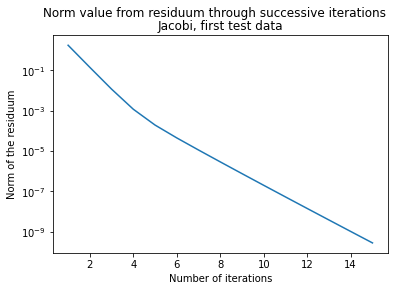

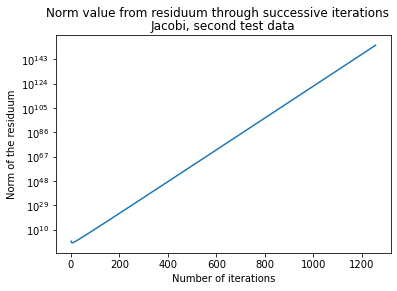

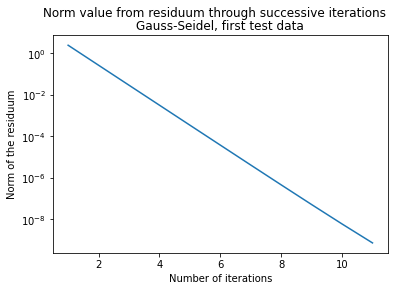

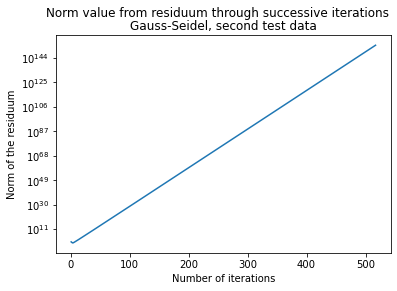

In [7]:
plt.figure(1)
plt.semilogy([i for i in range(1, jacobi_iterations + 1)], jacobi_norm)
plt.suptitle("Norm value from residuum through successive iterations")
plt.title("Jacobi, first test data")
plt.xlabel("Number of iterations")
plt.ylabel("Norm of the residuum")

plt.figure(2)
plt.semilogy([i for i in range(1, jacobi_iterations_2 + 1)], jacobi_norm_2)
plt.suptitle("Norm value from residuum through successive iterations")
plt.title("Jacobi, second test data")
plt.xlabel("Number of iterations")
plt.ylabel("Norm of the residuum")

plt.figure(3)
plt.semilogy([i for i in range(1, gauss_iterations + 1)], gauss_norm)
plt.suptitle("Norm value from residuum through successive iterations")
plt.title("Gauss-Seidel, first test data")
plt.xlabel("Number of iterations")
plt.ylabel("Norm of the residuum")

plt.figure(4)
plt.semilogy([i for i in range(1, gauss_iterations_2 + 1)], gauss_norm_2)
plt.suptitle("Norm value from residuum through successive iterations")
plt.title("Gauss-Seidel, second test data")
plt.xlabel("Number of iterations")
plt.ylabel("Norm of the residuum")

plt.show()

Na powyższych wykresach widać dokładnie, jak ważny jest dobór metody rozwiązania układu.
Dodatkowy warunek zbieżności dla metody Jacobiego: [promień spektranly](https://en.wikipedia.org/wiki/Spectral_radius) macierzy $\textbf{D}^{-1}(\textbf{L} + \textbf{U})$, jest mniejszy od 1.
Dodatkowy warunek zbieżności dla metody Gaussa-Seidla: $\textbf{A}$ jest symetryczna, dodatnio określona.

Pojawia się więc pytanie, co zrobić, kiedy nasza metoda się nie zbiega.
Jednym z rozwiązań jest użycie metody bezpośredniej!

### Metody bezpośrednie
Metody bezpośrednie charakteryzują się tym, że nie potrzebują żadnych warunków, aby uzyskać wynik. Ich wadą natomiast jest czas działania.

### Faktoryzacja LU
Faktoryzacja LU dzieli macierz na dwie macierze, trójkątną dolną $\textbf{L}$ oraz górną $\textbf{U}$. Poniższa, implementacja zwraca również macierz permutacji $\textbf{P}$, ponieważ zastosowana została strategia: *partial pivoting*.
$$
    \textbf{PA} = \textbf{LU}
$$
Faktoryzację LU klasyfikuje się jako jeden z wariantów metody eliminacji Gaussa. Jest szczególnie przydatna, kiedy układ równań musi być rozwiązany dla wielu prawych stron, natomiast lewa strona równania się nie zmienia.

In [8]:
def lu_decomposition(a: Matrix):
    upper = deepcopy(a)
    lower = ones(a.rows)
    perm = ones(a.rows)

    for k in range(a.rows - 1):
        max_row_index = upper.get_max_abs_in_col_below_row(k, k)
        if max_row_index != k:
            upper.swap_rows(k, max_row_index, perm)
            lower.swap_rows(k, max_row_index, n=k)

        for j in range(k+1, a.rows):
            value = upper[j, k] / upper[k, k]
            lower[j, k] = value

            for i in range(k, a.rows):
                value = upper[j, i] - lower[j, k] * upper[k, i]
                if abs(value) < 1e-15:
                    value = 0
                upper[j, i] = value
    return lower, upper, perm

Do rozwiązania układu równań wykorzystując faktoryzację LU, wykorzystam wcześniej już opisany algorytm **forward substitution** oraz algorytm **backward substitution**, który jest bardzo podobny do poprzedniego. Tym razem wykorzystamy go do rozwiązania układu z macierzą $\textbf{U}$.
$$
    x_m = \frac{b_m}{a_{mm}} \\
    x_{m-1} = \frac{b_{m-1} - a_{m-1,m}x_m}{a_{m-1,m-1}} \\
    x_{m-2} = \frac{b_{m-2} - a_{m-2,m-1}x_{m-1} - a_{m-2,m}x_m}{a_{m-2,m-2}} \\
    \vdots \\
    x_1 = \frac{b_1 - \sum_{i=2}^{m}a_{1i}x_i}{a_{11}}
$$

In [9]:
def lu_solver(a: Matrix, b: Matrix):
    lower, upper, perm = lu_decomposition(a)
    b = perm * b

    result = Matrix(size=b.size)
    for c in range(b.cols):
        col = b.get_col(c)

        lower_res = forward_substitution_solver(lower, Matrix(from_list=[[i] for i in col]))
        upper_res = backward_substitution_solver(upper, lower_res)
        result.set_col(c, upper_res.get_col(0))

    return result

Dla danych testowych, na których nie zadziałały metody iteracyjne, jesteśmy w stanie uzyskać przybliżenie rozwiązania z błędem wynoszącym:

In [10]:
results = lu_solver(matrix_a, vector_b)
print(euclidean_norm(matrix_a * results - vector_b))

5.293261474521974e-15


## Ostateczne porównanie
Na koniec zestawienie wszystkich metod obok siebie. Macierze testowe są takie same jak w pierwszym przypadku, tylko różnią się rozmiarem.

In [11]:
jacobi_time = {}
gauss_time = {}
lu_time = {}
for n in [100, 500, 1000, 2000, 3000]:
    matrix_a, vector_b = generate_test_data(n, a1, a2, a3, f)

    start_time = time.time()
    jacobi(matrix_a, vector_b, eps)
    jacobi_time[n] = time.time() - start_time

    start_time = time.time()
    gauss_seidel(matrix_a, vector_b, eps)
    gauss_time[n] = time.time() - start_time

    start_time = time.time()
    lu_solver(matrix_a, vector_b)
    lu_time[n] = time.time() - start_time

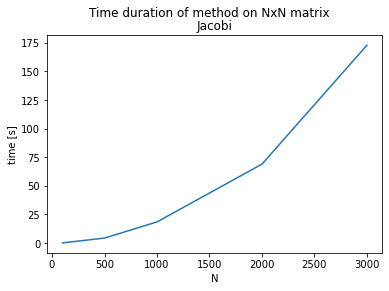

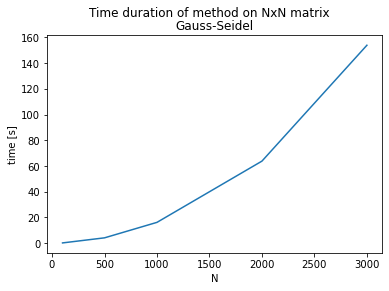

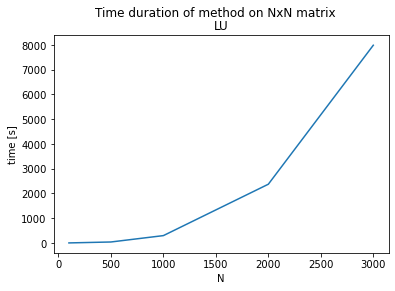

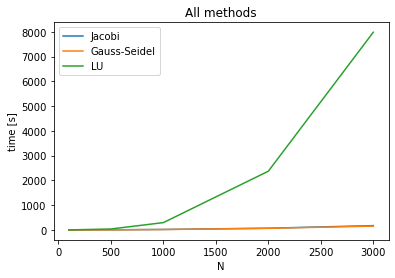

In [22]:
plt.figure(1)
plt.plot(jacobi_time.keys(), jacobi_time.values())
plt.suptitle("Time duration of method on NxN matrix")
plt.title("Jacobi")
plt.xlabel("N")
plt.ylabel("time [s]")

plt.figure(2)
plt.plot(gauss_time.keys(), gauss_time.values())
plt.suptitle("Time duration of method on NxN matrix")
plt.title("Gauss-Seidel")
plt.xlabel("N")
plt.ylabel("time [s]")

plt.figure(3)
plt.plot(lu_time.keys(), lu_time.values())
plt.suptitle("Time duration of method on NxN matrix")
plt.title("LU")
plt.xlabel("N")
plt.ylabel("time [s]")

plt.figure(4)
plt.title("All methods")
plt.plot(jacobi_time.keys(), jacobi_time.values(), label="Jacobi")
plt.plot(gauss_time.keys(), gauss_time.values(), label="Gauss-Seidel")
plt.plot(lu_time.keys(), lu_time.values(), label="LU")
plt.xlabel("N")
plt.ylabel("time [s]")
plt.legend()

## Podsumowanie
Z powyższych wykresów możemy odczytać, że metoda LU zgodnie z przewidywaniami zajęła najwięcej czasu. Różnica pomiędzy metodami Jacobiego oraz Gaussa-Seidla wyniosła około 15 sekund, dla macierzy o rozmiarze $3000 \times 3000$. Wyniki dobrze obrazują, jak dużo możemy zyskać, dobierając odpowiednią metodą rozwiązywania układu macierzowego.

## Źródła
    1. https://en.wikipedia.org/wiki/Band_matrix
    2. https://en.wikipedia.org/wiki/Jacobi_method
    3. https://en.wikipedia.org/wiki/Gauss%E2%80%93Seidel_method
    4. https://www.gaussianwaves.com/2013/05/solving-a-triangular-matrix-using-forward-backward-substitution/